# Part 1

In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Get the data 
df = pd.read_csv("football.csv", sep=";")
df = df.dropna()
display(df.columns)

X = df.drop(columns="GoalsScored")
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df["GoalsScored"]

Index(['X_ScoreRateH', 'X_ScoreRateA', 'X_ConcedeRateH', 'X_ConcedeRateA',
       'X_CornerRatioH', 'X_CornerRatioA', 'X_FoulRatioH', 'X_FoulRatioA',
       'GoalsScored'],
      dtype='object')

In [45]:
import pymc as pm

# Modeling 
with pm.Model() as model:
    beta = pm.Normal("beta", mu = 0, sigma = 5, shape = X.shape[1])
    
    intercept = pm.Normal("intercept", mu=0, sigma=5)

    mu = pm.math.exp(intercept + pm.math.dot(X, beta))

    y_obs = pm.Poisson("y_obs", mu=mu, observed = y)

    trace = pm.sample(1000,chains=4, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.999,0.014,0.973,1.027,0.0,0.0,5876.0,3155.0,1.0
beta[0],0.082,0.016,0.051,0.112,0.0,0.0,5767.0,3395.0,1.0
beta[1],0.034,0.018,0.003,0.070,0.0,0.0,6271.0,2840.0,1.0
beta[2],-0.049,0.017,-0.083,-0.018,0.0,0.0,6433.0,3065.0,1.0
beta[3],0.011,0.016,-0.018,0.043,0.0,0.0,6158.0,2820.0,1.0
beta[4],0.015,0.017,-0.015,0.048,0.0,0.0,6109.0,3228.0,1.0
beta[5],-0.000,0.017,-0.032,0.031,0.0,0.0,6161.0,2798.0,1.0
beta[6],-0.052,0.016,-0.083,-0.023,0.0,0.0,5909.0,3220.0,1.0
beta[7],-0.019,0.016,-0.051,0.010,0.0,0.0,6049.0,2891.0,1.0


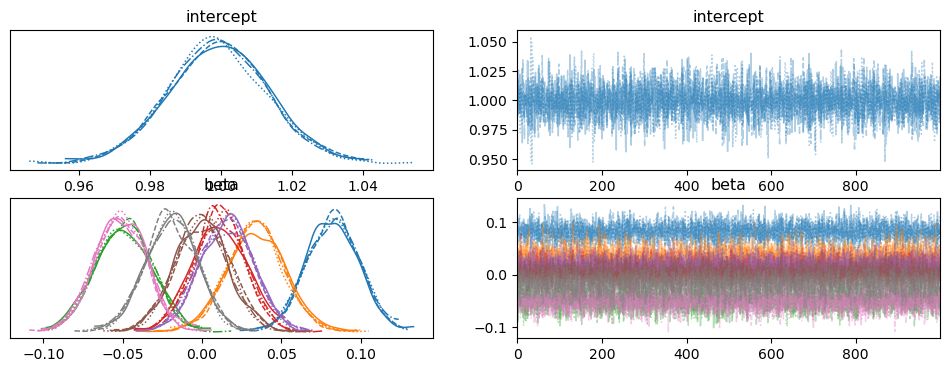

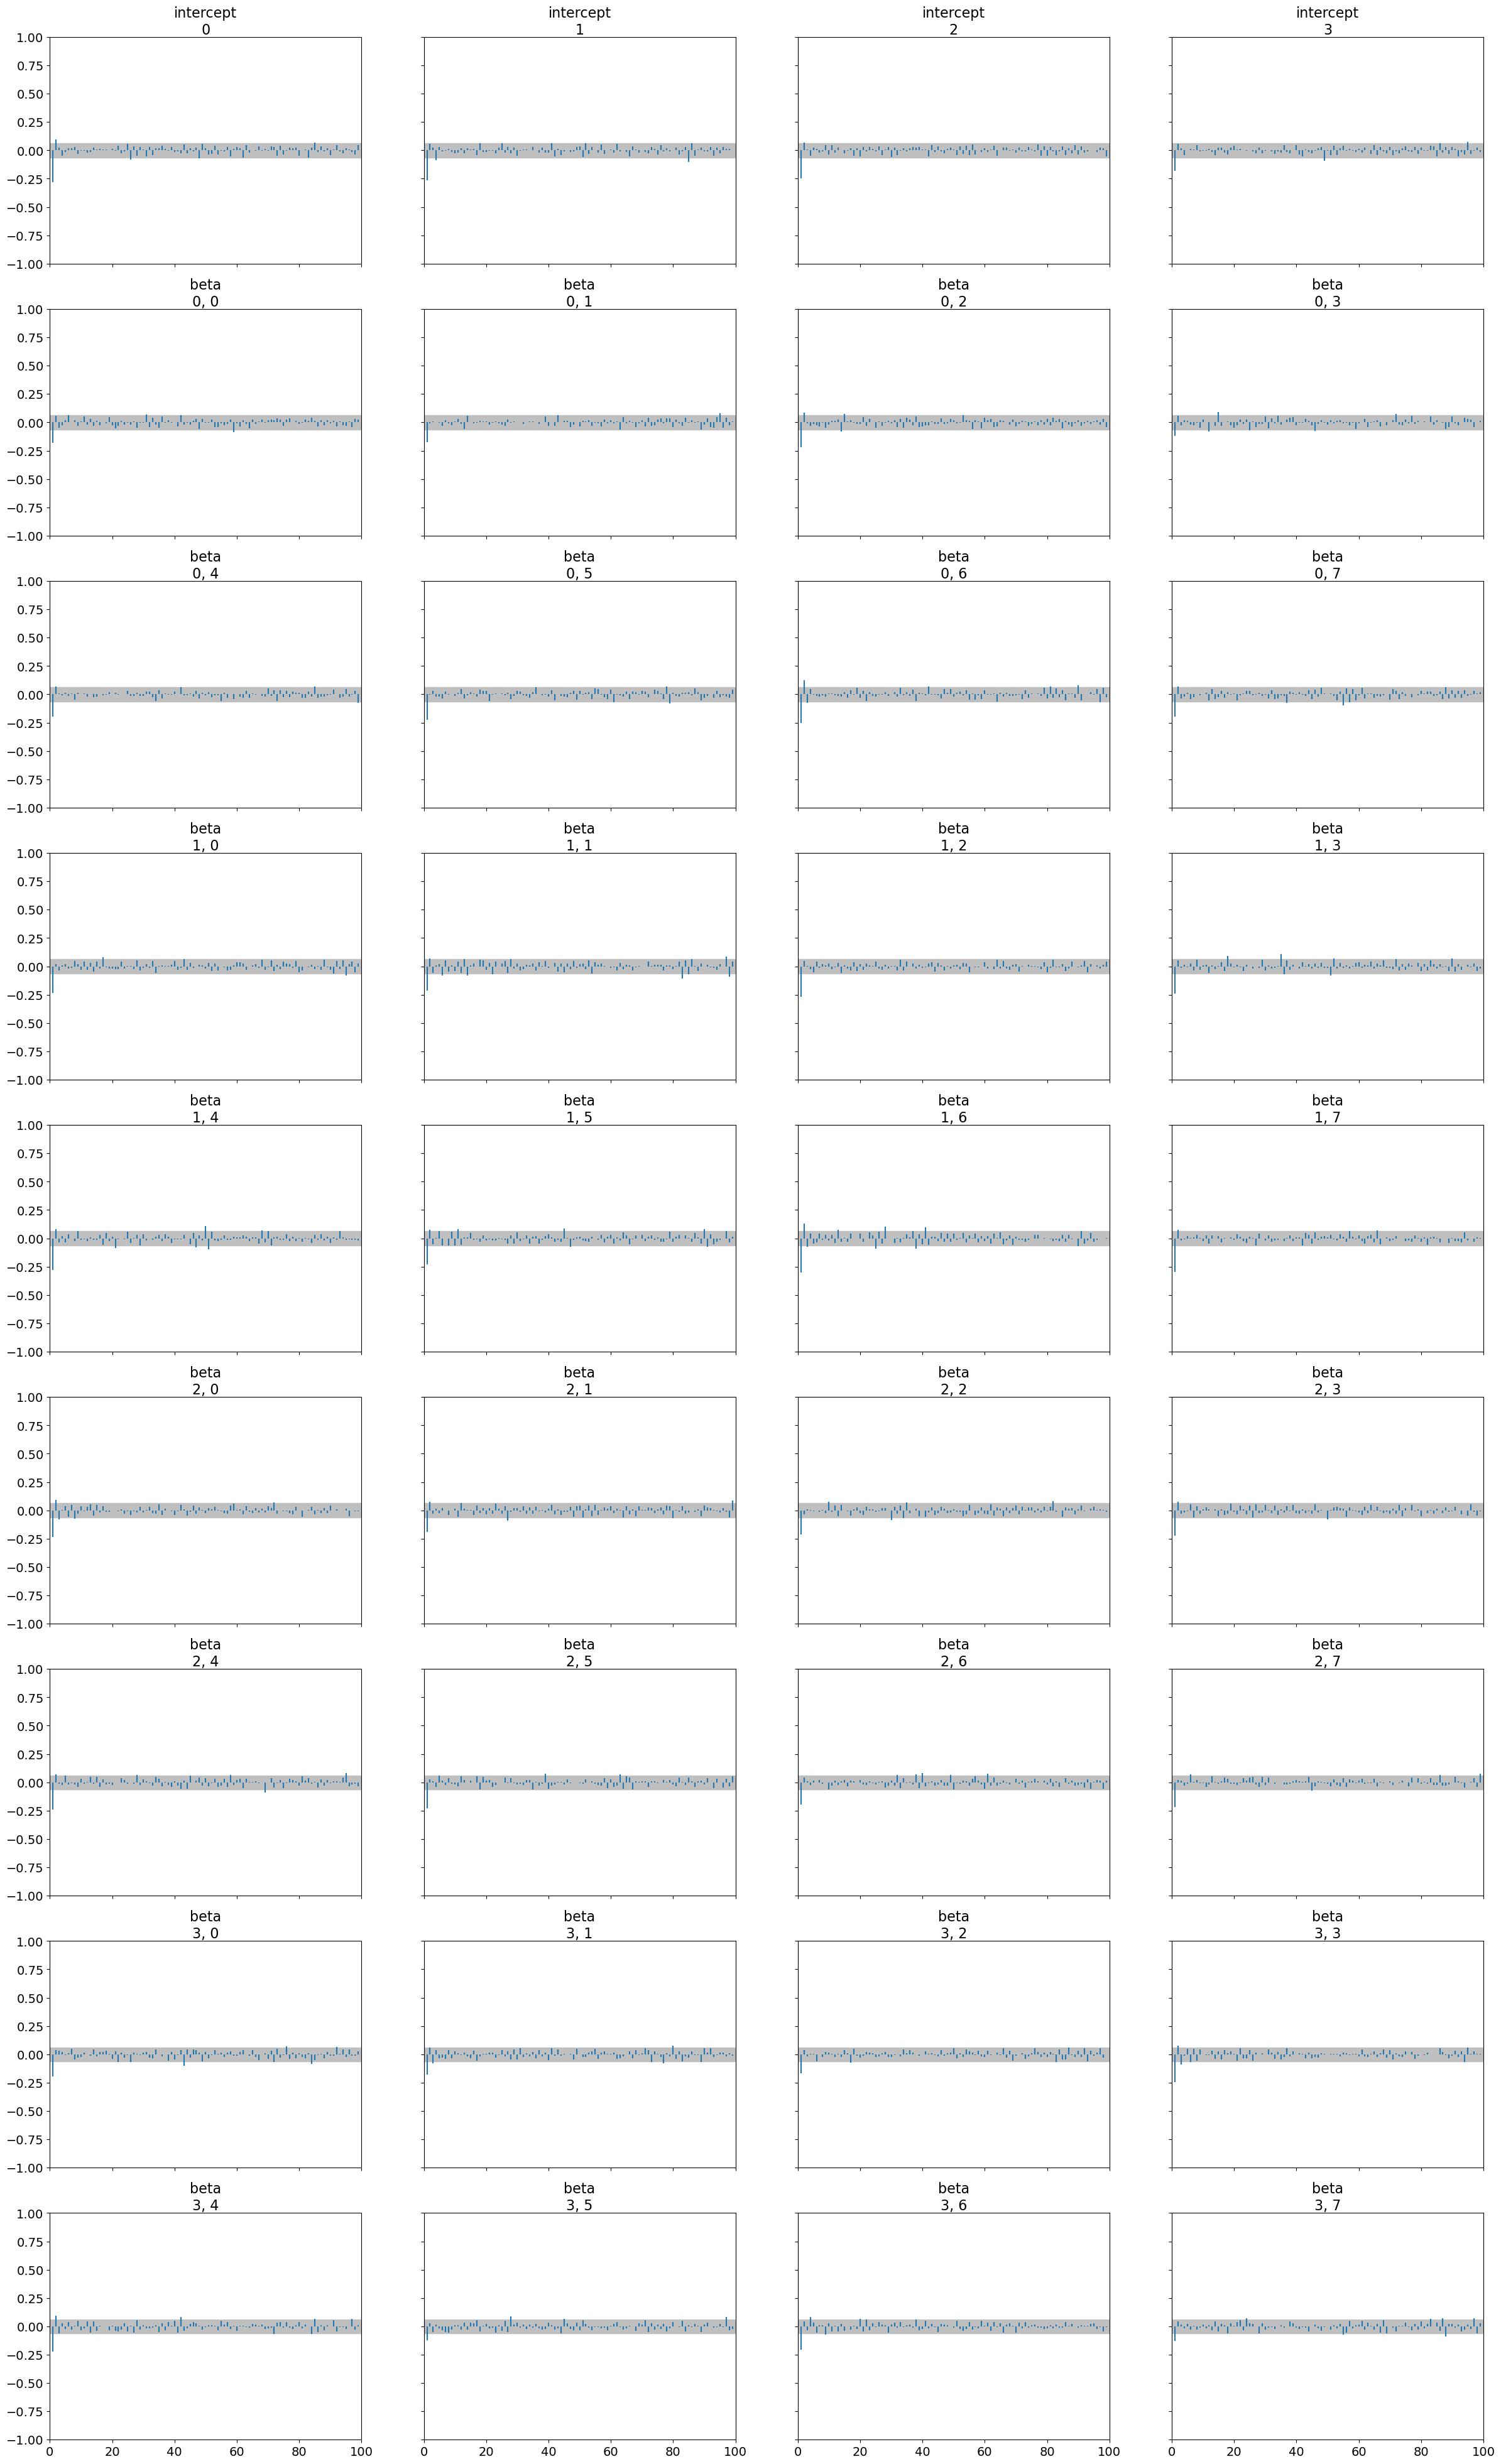

In [46]:
import arviz as az

# Diagnostic plots
az.plot_trace(trace, var_names=["intercept", "beta"])
az.plot_autocorr(trace, var_names=["intercept", "beta"])

# summary, more disagnostics
az.summary(trace, var_names=["intercept", "beta"]) 